# Protein Secondary Structure Prediction with Recurrent Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torch.utils import data
import torch.utils.data as utils
from torch.nn.utils.rnn import pad_sequence ,pack_padded_sequence,pad_packed_sequence
import random
import os
import math
import pickle
import time
import tqdm
from sklearn.metrics import accuracy_score,classification_report
from matplotlib import pyplot as plt
%matplotlib inline

### Set Random Number Initializers for Repeatability

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
target_names=["H","E","C"]
residue_names = ['A', 'C', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y', 'X','NoSeq']

#### Set device for the model to run on.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)
cpu = torch.device("cpu")

cuda


### Dataloader


In [5]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class Dataset(data.Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        pssm = dict["pssm"]
        length = len(seq)
        
        secstr = dict["secstr"]
        secstr_q3 = dict["secstr_q3"]

        return id,seq,pssm,length,secstr,secstr_q3
    
# Helper Function to pad a batch of protein sequences.
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, length) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    batch_size = len(DataLoaderBatch)
    batch_split = list(zip(*DataLoaderBatch))

    ids, seqs, pssms, lengths, secstrs, secstrs_q3 = batch_split[0], batch_split[1], batch_split[2] ,batch_split[3], batch_split[4], batch_split[5]
    max_length = max(lengths)

    padded_seqs = np.ones((max_length, batch_size))*30
    padded_pssms = np.zeros((max_length,batch_size,22))
    padded_secstrs = np.ones((max_length,batch_size))*30
    padded_secstrs_q3 = np.ones((max_length,batch_size))*30
    
    for i, l in enumerate(lengths):
        padded_seqs[:l,i] = seqs[i][:l]
        padded_pssms[:l,i,:] = pssms[i][:l][:]
        padded_secstrs[:l,i] = secstrs[i][:l]
        padded_secstrs_q3[:l,i] = secstrs_q3[i][:l]
    return torch.tensor(padded_seqs).type(torch.LongTensor), torch.tensor(padded_pssms).type(torch.float), torch.tensor(lengths), torch.tensor(padded_secstrs).type(torch.LongTensor), torch.tensor(padded_secstrs_q3).type(torch.LongTensor)

### Load data

In [6]:
# Batch Size for data parallelism
batch_size = 64

# Load train, test and validation data
train = Dataset("./Datasets/train.pkl")
val = Dataset("./Datasets/val.pkl")
test = Dataset("./Datasets/test.pkl")

# Data Generators for each set.
train_gen = data.DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=pad_batch,num_workers=1)
val_gen = data.DataLoader(val, batch_size=batch_size,shuffle=False,collate_fn=pad_batch,num_workers=1)
test_gen = data.DataLoader(test, batch_size=batch_size,shuffle=False,collate_fn=pad_batch,num_workers=1)

### Helper module for perceptron layer

In [7]:
# Dense Layer
class Dense(nn.Module):
    def __init__(self,input_dim,output_dim,dropout = 0.2,normalization = True,activation = F.relu):
        super(Dense, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_rate = dropout
        self.activation = activation
        self.n_state = normalization        
        self.linear = nn.Linear(self.input_dim,self.output_dim)
        self.layernorm = nn.LayerNorm(self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        if self.n_state:
            x = self.layernorm(x)
        x = self.dropout(x)
        return x

### Helper module for Bidirectional GRU 

In [8]:
# Bidirectional GRU
class gru_bidirectional(nn.Module):
    def __init__(self,inp,out,dropout=0.1,activation=F.relu):
        super(gru_bidirectional,self).__init__()
        self.gru = nn.GRU(inp,out,bidirectional=True)
        self.dropout_rate = dropout
        self.layernorm = nn.LayerNorm(2*out)
        self.activation = activation
        self.input_dim = inp
        self.output_dim = out
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self,x,lengths):
        x_ = pack_padded_sequence(x,lengths,enforce_sorted=False)
        out,_ = self.gru(x_)
        out,_ = pad_packed_sequence(out)
        out = self.activation(out)
        out = self.layernorm(out)
        if self.input_dim == 2*self.output_dim:
            out = out+x
        out = self.dropout(out)
        return out

### The Neural network definition

The structure of the neural network is defined here

In [9]:
class Net(nn.Module):
    def __init__(self,embedding_count=31,embedding_dim=50):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(embedding_count,embedding_dim=embedding_dim,padding_idx=30)
        
        self.layernorm = nn.LayerNorm(22+embedding_dim)
        
        #GRU
        self.gru_1 = gru_bidirectional(22+embedding_dim,64,0.2)
        
        #Output layers
        self.linear_1 = Dense(128,64)
        self.Q3 = Dense(64,3,dropout=0)
        
    def forward(self,x,pssm,x_lengths):
        emb = self.embedding(x)
        emb = torch.cat([emb,pssm],dim=-1)

        x_normalized = self.layernorm(emb)
        
        gru = self.gru_1(x_normalized,x_lengths)
        
        out = self.linear_1(gru)
        Q3 = self.Q3(out)
        return Q3

### Initialize the network, Optimizer and the loss function

In [10]:
network = Net().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=30)
optimizer = torch.optim.Adam(network.parameters(),lr=0.001)

### Train Epoch helper Function

In [11]:
def train_epoch(generator):
    #     Set the network in to train mode
    #     Enables dropout. 
    network.train()
    total_loss = 0.
    start_time = time.time() # Track training time.
    prediction = []
    g_t = []
    for seq,pssm,length,q8,q3 in (generator):
        optimizer.zero_grad()  # Make all gradients at each trainable parameter zero.
        output = network(seq.to(device),pssm.to(device),length.to(device)) # Perform a forward pass
        
        loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))  #Compute the loss function 
        loss.backward() # Perform back propagation 
        torch.nn.utils.clip_grad_norm_(network.parameters(), 0.5)  # Clip gradients to increase stability of training
        optimizer.step()  # Perform the optimization step.
        
        total_loss += loss.cpu().detach().numpy()/batch_size   # Track loss for analysis
        
        # store all predictions to calculate accuracy at end of epoch
        for i in range(len(length)):
            prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
            g_t.append(q3[0:length[i],i].cpu().detach().numpy())

    predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
    g_ts = np.concatenate(g_t)
    
    # calculate accuracy
    acc = accuracy_score(predictions,g_ts) 
    end_time = time.time()
    return end_time-start_time , total_loss, acc

### Evaluation Epoch Helper function

In [12]:
def evaluate(generator, print_acc_report=False,output_sample=False):
    
    with torch.no_grad(): # disable gradients as no optimization done during evaluation
        network.eval()  # set network to evaluation mode to disable dropouts
        total_loss = 0.
        start_time = time.time() # Track evaluation time
        prediction = []
        g_t = []   
        for seq,pssm,length,q8,q3 in (generator):
            
            #    Get predictions
            output = network(seq.to(device),pssm.to(device),length.to(device))
            
            #    Calculate loss for analysis
            loss = criterion(output.view(-1,3).to(device),q3.view(-1).to(device))        
            total_loss += loss.cpu().detach().numpy()/batch_size
            for i in range(len(length)):
                prediction.append(output[0:length[i],i,:].cpu().detach().numpy())
                g_t.append(q3[0:length[i],i].cpu().detach().numpy())
                
        #   calculate  accuracy for analysis       
        predictions = np.argmax(np.concatenate(prediction,axis=0),axis=-1)
        g_ts = np.concatenate(g_t)
        acc = accuracy_score(predictions,g_ts) 
        end_time = time.time()
        if print_acc_report:
            print (classification_report(g_ts,predictions,target_names=target_names))
    return end_time-start_time, total_loss, acc

### Train!!!

In [13]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
for i in range(40):
    #     Train epoch
    run_time,train_loss,train_acc = train_epoch(train_gen)
    
    #     Validation step
    _,val_loss,val_acc = evaluate(val_gen)
    
    #     Track performance of network during training
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    #     Print performance metrics
    print ("Epoch : "+str(i)+", Train_loss : "+str(train_loss)+", Train_acc : "+str(train_acc)+", Val_acc : "+ str(val_acc))

Epoch : 0, Train_loss : 1.2612319448962808, Train_acc : 0.6009002598959364, Val_acc : 0.6678565633619991
Epoch : 1, Train_loss : 1.0200444497168064, Train_acc : 0.6994171180817822, Val_acc : 0.7449294174914814
Epoch : 2, Train_loss : 0.8763319170102477, Train_acc : 0.7506094323122677, Val_acc : 0.7779287684569204
Epoch : 3, Train_loss : 0.8094869237393141, Train_acc : 0.7721967428011629, Val_acc : 0.7903212721077397
Epoch : 4, Train_loss : 0.7722388077527285, Train_acc : 0.7824804201797014, Val_acc : 0.798839850722051
Epoch : 5, Train_loss : 0.7427989160642028, Train_acc : 0.7902956995371644, Val_acc : 0.8031194223592406
Epoch : 6, Train_loss : 0.7158476538024843, Train_acc : 0.7979015549943657, Val_acc : 0.803504786629888
Epoch : 7, Train_loss : 0.6895751976408064, Train_acc : 0.8045926047951939, Val_acc : 0.8144369625182541
Epoch : 8, Train_loss : 0.6714003579691052, Train_acc : 0.809188539342777, Val_acc : 0.8176415706636379
Epoch : 9, Train_loss : 0.6535391467623413, Train_acc : 0.

### Evaluate on test set

In [14]:
_,_,test_accuracy = evaluate(test_gen,True,True)
print ("Test Accuracy - ",test_accuracy)

              precision    recall  f1-score   support

           H       0.90      0.88      0.89     19553
           E       0.81      0.76      0.79     11847
           C       0.80      0.84      0.82     23544

   micro avg       0.84      0.84      0.84     54944
   macro avg       0.84      0.83      0.83     54944
weighted avg       0.84      0.84      0.84     54944

Test Accuracy -  0.8386539021549214


### Visualize training

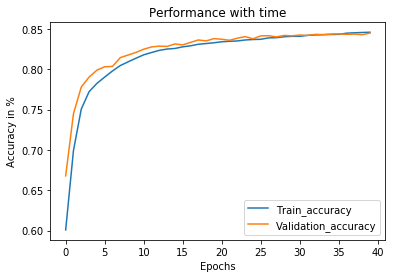

In [19]:
plt.plot(train_acc_history,label = "Train_accuracy")
plt.plot(val_acc_history,label = "Validation_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy in %")
plt.title("Performance with time")
plt.show()

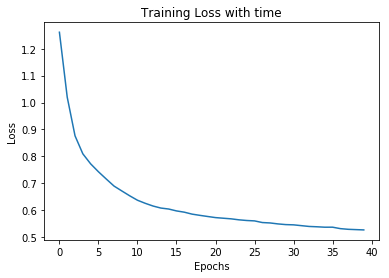

In [16]:
plt.plot(train_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss with time")
plt.show()